### ***                 CHỦ ĐỀ:  ỨNG DỤNG MÔ HÌNH HỌC MÁY VÀO DỰ ĐOÁN SỐ ĐIỆN SỬ DỤNG TRONG THÁNG***


# Cách sử dụng trên Google Colab:

---




**Bước 1: Cài đặt kagglehub (chạy cell đầu tiên)**

**Bước 2: Xác thực Kaggle (Ở đây dataset ta chọn electric-power-consumption-data-set là public nên không cần xác thực)**

**Bước 3: Chạy các cell theo thứ tự**


---




In [183]:
#Cài đặt và import các thư viện cần thiết
!pip install kagglehub[pandas-datasets]
# Cài đặt optuna (nếu chưa có)
!pip install optuna

# Import các thư viện cần thiết cho quá trình tối ưu
import optuna
from sklearn.linear_model import Ridge, Lasso, LinearRegression
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import kagglehub
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
import xgboost as xgb
import warnings

warnings.filterwarnings('ignore')
plt.style.use('seaborn-v0_8')

# **1. TIỀN XỬ LÝ DỮ LIỆU (PREPROCESSING)**

---


*1.1. Tải và Làm sạch dữ liệu*

---



In [184]:
# 1.1 Tải dữ liệu
path = kagglehub.dataset_download("uciml/electric-power-consumption-data-set")
df = pd.read_csv(f"{path}/household_power_consumption.txt", sep=';',
                 parse_dates={'datetime': ['Date', 'Time']},
                 infer_datetime_format=True,
                 low_memory=False, na_values=['?'])
df.set_index('datetime', inplace=True)

# 1.2 Gom nhóm theo ngày (Resampling)
df_daily = df['Global_active_power'].resample('D').sum().to_frame()

# 1.3 Xử lý dữ liệu thiếu (Interpolation)
df_daily['Global_active_power'] = df_daily['Global_active_power'].interpolate(method='time')

# 1.4 Xử lý giá trị ngoại lai (Outlier Handling) - GIÚP GIẢM SAI SỐ
# Giới hạn giá trị ở mức phân vị 99% để loại bỏ các đỉnh nhiễu bất thường
upper_limit = df_daily['Global_active_power'].quantile(0.99)
df_daily['Global_active_power'] = df_daily['Global_active_power'].clip(upper=upper_limit)

print(f"✓ Hoàn thành tiền xử lý. Số dòng: {len(df_daily)}")

Using Colab cache for faster access to the 'electric-power-consumption-data-set' dataset.
✓ Hoàn thành tiền xử lý. Số dòng: 1442






---

**2. KHÁM PHÁ DỮ LIỆU TRỰC QUAN (EDA)**
---
2.1. Phân bổ Biến mục tiêu

---




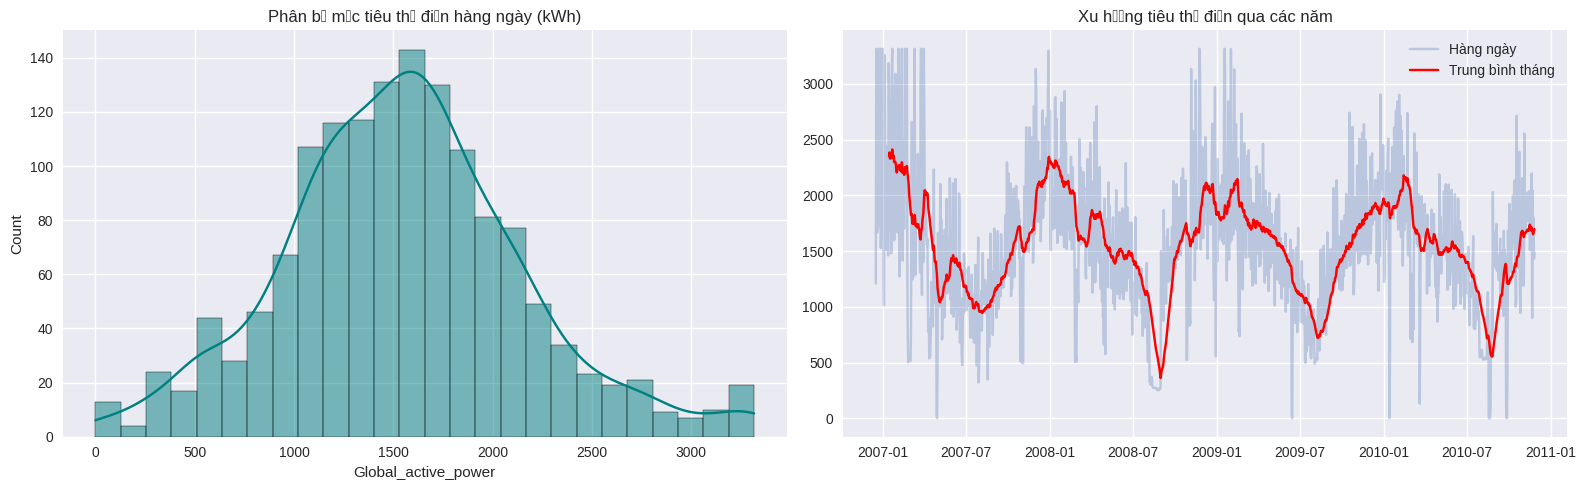

In [185]:
fig, axes = plt.subplots(1, 2, figsize=(16, 5))

# Biểu đồ 1: Phân bổ tiêu thụ điện
sns.histplot(df_daily['Global_active_power'], kde=True, ax=axes[0], color='teal')
axes[0].set_title('Phân bổ mức tiêu thụ điện hàng ngày (kWh)')

# Biểu đồ 2: Xu hướng dài hạn (Rolling Mean)
axes[1].plot(df_daily['Global_active_power'], alpha=0.3, label='Hàng ngày')
axes[1].plot(df_daily['Global_active_power'].rolling(30).mean(), color='red', label='Trung bình tháng')
axes[1].set_title('Xu hướng tiêu thụ điện qua các năm')
axes[1].legend()

plt.tight_layout()
plt.show()



---
## **3.FEATURE ENGINEERING (KỸ THUẬT ĐẶC TRƯNG)**

---

3.1 Biến đổi chuỗi thời gian thành bài toán Học máy có giám sát.

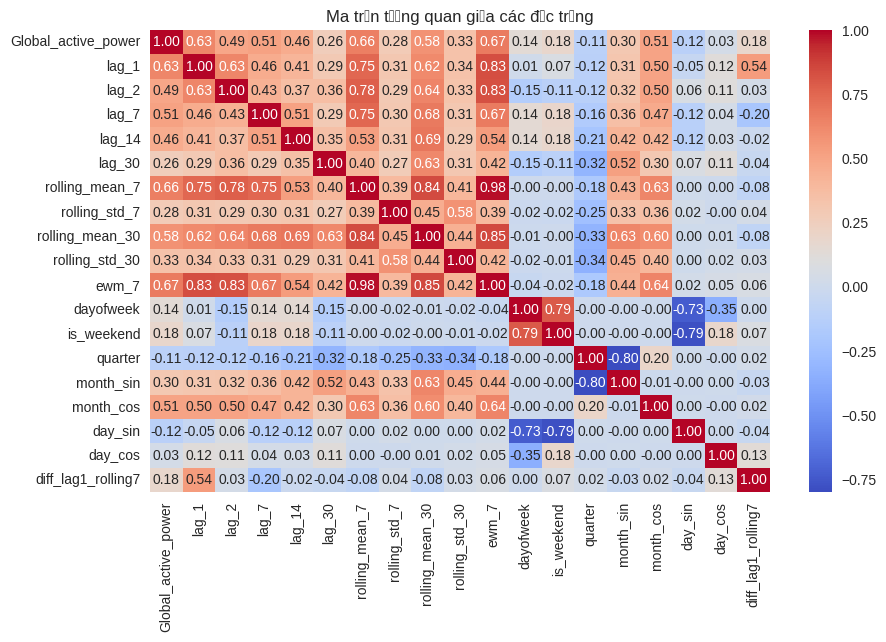

In [186]:
def create_advance_features(df):
    df = df.copy()

    # 1. Biến mục tiêu (Target)
    target = 'Global_active_power'

    # 2. Tạo Lags (Cực kỳ quan trọng cho Time Series)
    # Thêm lag 1 ngày, 2 ngày và 1 tuần để bắt kịp xu hướng gần nhất
    for i in [1, 2, 7, 14, 30]:
        df[f'lag_{i}'] = df[target].shift(i)

    # 3. Rolling Statistics (Tính ổn định)
    # Giúp mô hình biết được mức tiêu thụ trung bình của tuần trước/tháng trước
    window_sizes = [7, 30]
    for w in window_sizes:
        df[f'rolling_mean_{w}'] = df[target].shift(1).rolling(window=w).mean()
        df[f'rolling_std_{w}'] = df[target].shift(1).rolling(window=w).std()

    # 4. Exponentially Weighted Moving Average (EWMA)
    # Nhấn mạnh vào các giá trị gần hiện tại hơn
    df['ewm_7'] = df[target].shift(1).ewm(span=7, adjust=False).mean()

    # 5. Đặc trưng thời gian chi tiết
    df['dayofweek'] = df.index.dayofweek
    df['is_weekend'] = df['dayofweek'].isin([5, 6]).astype(int)
    df['quarter'] = df.index.quarter

    # Encoding chu kỳ (Sin/Cos) cho cả Tháng và Ngày trong tuần
    df['month_sin'] = np.sin(2 * np.pi * df.index.month / 12)
    df['month_cos'] = np.cos(2 * np.pi * df.index.month / 12)
    df['day_sin'] = np.sin(2 * np.pi * df.index.dayofweek / 7)
    df['day_cos'] = np.cos(2 * np.pi * df.index.dayofweek / 7)

    # 6. Biến tương tác (Interaction Features)
    # Ví dụ: Tỷ lệ giữa giá trị hôm qua so với trung bình tuần
    df['diff_lag1_rolling7'] = df['lag_1'] / (df['rolling_mean_7'] + 1e-5)

    return df.dropna()

data = create_advance_features(df_daily)

# Vẽ ma trận tương quan để xem biến nào ảnh hưởng nhất
plt.figure(figsize=(10, 6))
sns.heatmap(data.corr(), annot=True, fmt='.2f', cmap='coolwarm')
plt.title('Ma trận tương quan giữa các đặc trưng')
plt.show()

## **4. HUẤN LUYỆN VÀ DỰ BÁO CUỐN CHIẾU (RECURSIVE FORECASTING)**

---
4.1. Chia dữ liệu và Chuẩn hóa

---




In [187]:
n = len(data)
# Xác định các điểm cắt dữ liệu theo thời gian (70% - 15% - 15%)
train_end = int(n * 0.7)
val_end = int(n * 0.85)

train_df = data.iloc[:train_end]
val_df = data.iloc[train_end:val_end]
test_df = data.iloc[val_end:]
train_val_df = data.iloc[:val_end] # Tập gộp để huấn luyện lại sau khi tối ưu

# Chuẩn hóa: Chỉ học thông số (fit) từ tập huấn luyện ban đầu
scaler = MinMaxScaler()
X_train = train_df.drop('Global_active_power', axis=1)
y_train = train_df['Global_active_power']
X_train_scaled = scaler.fit_transform(X_train)

# Chuẩn bị dữ liệu Train+Val cho bước huấn luyện cuối cùng
X_train_val_scaled = scaler.transform(train_val_df.drop('Global_active_power', axis=1))
y_train_val = train_val_df['Global_active_power']

print(f"✓ Chia dữ liệu thành công: Train({len(train_df)}), Val({len(val_df)}), Test({len(test_df)})")

✓ Chia dữ liệu thành công: Train(988), Val(212), Test(212)




---

4.2. Workflow Dự báo cuốn chiếu

---



In [188]:
def recursive_forecast(model, scaler, history_df, steps=30):
    current_history = history_df.copy()
    forecasts = []
    for _ in range(steps):
        features = create_advance_features(current_history)
        X_next_df = features.iloc[-1:].drop('Global_active_power', axis=1)

        # Ensure X_next_df has the same columns as the original X_train DataFrame
        # X_train is the original DataFrame used to fit the scaler.
        X_next = X_next_df.reindex(columns=X_train.columns, fill_value=0)

        X_next_scaled = scaler.transform(X_next)
        y_pred = max(0, model.predict(X_next_scaled)[0])
        forecasts.append(y_pred)

        next_date = current_history.index[-1] + pd.Timedelta(days=1)
        new_row = pd.DataFrame({'Global_active_power': [y_pred]}, index=[next_date])
        current_history = pd.concat([current_history, new_row])
    return np.array(forecasts)

## **5. THỰC NGHIỆM VÀ TỐI ƯU TỪNG MÔ HÌNH**

---

5.1. Hàm đánh giá mô hình trên Recursive Forecast

---



In [189]:
def get_recursive_metrics(model, scaler, df_daily, start_idx, steps=30):
    # Lấy dữ liệu lịch sử ngay trước thời điểm bắt đầu dự báo
    history_df = df_daily.iloc[start_idx - 35 : start_idx]
    actual = df_daily.iloc[start_idx : start_idx + steps]['Global_active_power']

    # Dự báo cuốn chiếu thực tế
    preds = recursive_forecast(model, scaler, history_df, steps=steps)

    # Tính toán các chỉ số hồi quy
    rmse = np.sqrt(mean_squared_error(actual, preds))
    mae = mean_absolute_error(actual, preds)
    mape = np.mean(np.abs((actual - preds) / (actual + 1e-10))) * 100
    r2 = r2_score(actual, preds)
    total_err = abs(actual.sum() - preds.sum()) / (actual.sum() + 1e-10) * 100

    return {
        'RMSE': rmse, 'MAE': mae, 'MAPE': mape, 'R2': r2,
        'Total_Err': total_err, 'Forecasts': preds, 'Actual': actual
    }



---



5.2 TỐI ƯU LINEAR REGRESSION

---



In [190]:
def optimize_linear_regression(df_daily, train_end, val_end, n_trials=50):
    def objective(trial):
        reg_type = trial.suggest_categorical('type', ['ridge', 'lasso']) # Bỏ 'none' để tránh Overfit
        # Tăng alpha lên để phạt nặng hơn
        alpha = trial.suggest_float('alpha', 0.1, 200.0, log=True)

        if reg_type == 'ridge': model = Ridge(alpha=alpha, random_state=42)
        else: model = Lasso(alpha=alpha, max_iter=10000, random_state=42)

        model.fit(X_train_scaled, y_train)

        # Lấy metrics tập Train để tính Gap
        train_res = get_recursive_metrics(model, scaler, df_daily, start_idx=train_end-30, steps=30)
        val_res = get_recursive_metrics(model, scaler, df_daily, start_idx=train_end, steps=(val_end-train_end))

        # TỐI ƯU: RMSE + Phạt khoảng cách (Gap)
        gap = abs(val_res['RMSE'] - train_res['RMSE'])
        return val_res['RMSE'] + 0.5 * gap # Cân bằng giữa chính xác và tổng quát

    study = optuna.create_study(direction='minimize', sampler=optuna.samplers.TPESampler(seed=42))
    study.optimize(objective, n_trials=n_trials)
    return study




---


5.3 TỐI ƯU RANDOM FOREST

---



In [191]:
def optimize_random_forest(df_daily, train_end, val_end, n_trials=100):
    print("\n" + "="*70 + "\nPHẦN: TỐI ƯU RANDOM FOREST (ROBUST VERSION)\n" + "="*70)
    sampler = optuna.samplers.TPESampler(seed=42)

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 300),
            'max_depth': trial.suggest_int('max_depth', 3, 6), # Ép nông
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 20),
            'max_features': 'sqrt', # Giới hạn số lượng biến để tránh tập trung vào 1 biến nhiễu
            'random_state': 42
        }

        model = RandomForestRegressor(**params).fit(X_train_scaled, y_train)

        tr_res = get_recursive_metrics(model, scaler, df_daily, train_end-30, 30)
        vl_res = get_recursive_metrics(model, scaler, df_daily, train_end, (val_end-train_end))

        if vl_res['R2'] < 0: return 9999

        gap = abs(vl_res['RMSE'] - tr_res['RMSE'])
        return vl_res['RMSE'] + 1.5 * gap

    study = optuna.create_study(direction='minimize', sampler=sampler)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    return study



---


5.4 TỐI ƯU GRADIENT BOOSTING

---



In [192]:
def optimize_gradient_boosting(df_daily, train_end, val_end, n_trials=100):
    print("\n" + "="*70 + "\nPHẦN: TỐI ƯU GRADIENT BOOSTING (ROBUST VERSION)\n" + "="*70)
    sampler = optuna.samplers.TPESampler(seed=42)

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.03, log=True),
            'max_depth': trial.suggest_int('max_depth', 2, 4), # Ép cây nông để chống học vẹt
            'subsample': trial.suggest_float('subsample', 0.6, 0.8),
            'min_samples_leaf': trial.suggest_int('min_samples_leaf', 5, 15),
            'random_state': 42
        }

        model = GradientBoostingRegressor(**params).fit(X_train_scaled, y_train)

        # Đánh giá Recursive trên cả Train và Val để tính Gap
        tr_res = get_recursive_metrics(model, scaler, df_daily, train_end-30, 30)
        vl_res = get_recursive_metrics(model, scaler, df_daily, train_end, (val_end-train_end))

        # Nếu R2 tập Val âm, loại bỏ Trial này ngay lập tức
        if vl_res['R2'] < 0: return 9999 + abs(vl_res['R2'])

        # Hàm mục tiêu: RMSE_Val + 2.0 * |RMSE_Val - RMSE_Train|
        # Trọng số 2.0 cực cao để ép Gap xuống thấp nhất có thể
        gap = abs(vl_res['RMSE'] - tr_res['RMSE'])
        return vl_res['RMSE'] + 2.0 * gap

    study = optuna.create_study(direction='minimize', sampler=sampler)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    return study



---


5.5 TỐI ƯU XGBOOST

---



In [193]:
def optimize_xgboost(df_daily, train_end, val_end, n_trials=100):
    print("\n" + "="*70 + "\nPHẦN: TỐI ƯU XGBOOST (ROBUST VERSION)\n" + "="*70)
    sampler = optuna.samplers.TPESampler(seed=42)

    def objective(trial):
        params = {
            'n_estimators': trial.suggest_int('n_estimators', 100, 500),
            'learning_rate': trial.suggest_float('learning_rate', 0.005, 0.03, log=True),
            'max_depth': trial.suggest_int('max_depth', 2, 4),
            'reg_lambda': trial.suggest_float('reg_lambda', 10.0, 100.0), # Phạt L2 cực mạnh
            'reg_alpha': trial.suggest_float('reg_alpha', 1.0, 50.0),    # Phạt L1 để triệt tiêu biến nhiễu
            'subsample': trial.suggest_float('subsample', 0.6, 0.8),
            'random_state': 42
        }

        model = xgb.XGBRegressor(**params).fit(X_train_scaled, y_train)

        tr_res = get_recursive_metrics(model, scaler, df_daily, train_end-30, 30)
        vl_res = get_recursive_metrics(model, scaler, df_daily, train_end, (val_end-train_end))

        if vl_res['R2'] < 0: return 9999 + abs(vl_res['R2'])

        gap = abs(vl_res['RMSE'] - tr_res['RMSE'])
        return vl_res['RMSE'] + 2.0 * gap

    study = optuna.create_study(direction='minimize', sampler=sampler)
    study.optimize(objective, n_trials=n_trials, show_progress_bar=True)
    return study

## **6. SO SÁNH VÀ ĐÁNH GIÁ KẾT QUẢ**

---

6.1. Thực hiện tối ưu các mô hình và so sánh
---



In [ ]:
def compare_optimized_models_standard(studies_dict, df_daily, train_end, val_end):
    results = {}

    for name, study in studies_dict.items():
        bp = study.best_params
        # Khởi tạo mô hình
        if name == 'Linear Regression':
            model = Ridge(alpha=bp['alpha'], random_state=42) if bp.get('type') == 'ridge' else \
                    Lasso(alpha=bp['alpha'], random_state=42) if bp.get('type') == 'lasso' else LinearRegression()
        elif name == 'Random Forest': model = RandomForestRegressor(**bp, random_state=42)
        elif name == 'Gradient Boosting': model = GradientBoostingRegressor(**bp, random_state=42)
        else: model = xgb.XGBRegressor(**bp, random_state=42)

        # --- GIAI ĐOẠN 1: ĐÁNH GIÁ OVERFITTING (Trên Train vs Validation) ---
        # Huấn luyện CHỈ trên tập Train (70%)
        model.fit(X_train_scaled, y_train)

        # Đo trên chính tập Train (30 ngày cuối tập Train)
        train_metrics = get_recursive_metrics(model, scaler, df_daily, start_idx=train_end-30, steps=30)
        # Đo trên tập Validation (để báo cáo Overfitting chuẩn)
        val_metrics = get_recursive_metrics(model, scaler, df_daily, start_idx=train_end, steps=(val_end-train_end))

        # --- GIAI ĐOẠN 2: TRAINING CUỐI CÙNG (Gộp Train + Val) ---
        # Huấn luyện lại trên 85% dữ liệu
        model.fit(X_train_val_scaled, y_train_val)

        # --- GIAI ĐOẠN 3: ĐO TRÊN TẬP TEST (Kết quả thực tế cho sếp/khách hàng) ---
        test_metrics = get_recursive_metrics(model, scaler, df_daily, start_idx=val_end, steps=30)

        results[name] = {
            'Train': train_metrics,
            'Val': val_metrics,
            'Test': test_metrics,
            'Best_Params': bp
        }
    return results

# Chạy tối ưu hóa
print("\n===== BẮT ĐẦU TỐI ƯU CHUẨN CHỈ ====")
studies = {
    'Linear Regression': optimize_linear_regression(df_daily, train_end, val_end, n_trials=50),
    'Random Forest': optimize_random_forest(df_daily, train_end, val_end, n_trials=50),
    'Gradient Boosting': optimize_gradient_boosting(df_daily, train_end, val_end, n_trials=50),
    'XGBoost': optimize_xgboost(df_daily, train_end, val_end, n_trials=50)
}
final_results = compare_optimized_models_standard(studies, df_daily, train_end, val_end)



---
6.2. In bảng tổng hợp kết quả chi tiết
---




In [195]:
def audit_single_model(name, data):
    """
    Phân tích chi tiết nội tại của một mô hình
    """
    tr = data['Train']
    ts = data['Test']

    # Tính toán các chỉ số chênh lệch
    rmse_gap = (ts['RMSE'] - tr['RMSE']) / (tr['RMSE'] + 1e-10) * 100
    mape_diff = ts['MAPE'] - tr['MAPE']

    print(f"\n" + "-"*30)
    print(f"PHÂN TÍCH MÔ HÌNH: {name}")
    print("-"*30)

    # Tạo bảng so sánh nội tại
    audit_df = pd.DataFrame({
        'Chỉ số': ['RMSE (kWh)', 'MAE (kWh)', 'MAPE (%)', 'R²'],
        'Tập Train': [tr['RMSE'], tr['MAE'], tr['MAPE'], tr['R2']],
        'Tập Test': [ts['RMSE'], ts['MAE'], ts['MAPE'], ts['R2']]
    })
    print(audit_df.to_string(index=False))

    # Đánh giá tình trạng Overfitting
    print(f"\n→ Overfit Gap (RMSE): {rmse_gap:.2f}%")
    if rmse_gap < 10: status = "Rất ổn định (Ideal)"
    elif rmse_gap < 25: status = "Overfit nhẹ (Acceptable)"
    else: status = "Overfit nặng (High Risk)"
    print(f"→ Đánh giá độ ổn định: {status}")



---

6.3 Tạo các biểu đồ so sánh

---



In [196]:
def plot_individual_robustness(name, data):
    tr_pred = data['Train']['Predictions']
    tr_act = data['Train']['Actual']
    ts_pred = data['Test']['Predictions']
    ts_act = data['Test']['Actual']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

    # Biểu đồ Train
    ax1.plot(tr_act.index, tr_act.values, label='Thực tế', color='gray', alpha=0.5)
    ax1.plot(tr_pred.index, tr_pred.values, label='Dự báo', color='green')
    ax1.set_title(f'{name} - Khả năng học (Train)')
    ax1.legend()

    # Biểu đồ Test
    ax2.plot(ts_act.index, ts_act.values, label='Thực tế', color='gray', alpha=0.5)
    ax2.plot(ts_pred.index, ts_pred.values, label='Dự báo', color='red')
    ax2.set_title(f'{name} - Khả năng dự báo (Test)')
    ax2.legend()

    plt.show()



---

6.3 Biểu đồ đường dự báo

---



In [ ]:
def plot_individual_robustness(name, data):
    tr_pred_array = data['Train']['Forecasts']
    tr_act = data['Train']['Actual']
    ts_pred_array = data['Test']['Forecasts']
    ts_act = data['Test']['Actual']

    # Convert forecast arrays to Pandas Series with the correct index for plotting
    tr_pred_series = pd.Series(tr_pred_array, index=tr_act.index)
    ts_pred_series = pd.Series(ts_pred_array, index=ts_act.index)

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

    # Biểu đồ Train
    ax1.plot(tr_act.index, tr_act.values, label='Thực tế', color='gray', alpha=0.5)
    ax1.plot(tr_pred_series.index, tr_pred_series.values, label='Dự báo', color='green')
    ax1.set_title(f'{name} - Khả năng học (Train)')
    ax1.legend()

    # Biểu đồ Test
    ax2.plot(ts_act.index, ts_act.values, label='Thực tế', color='gray', alpha=0.5)
    ax2.plot(ts_pred_series.index, ts_pred_series.values, label='Dự báo', color='red')
    ax2.set_title(f'{name} - Khả năng dự báo (Test)')
    ax2.legend()

    plt.show()
# BƯỚC 1: SOI TỪNG MÔ HÌNH
for name, data in final_results.items():
    audit_single_model(name, data)
    plot_individual_robustness(name, data)

# BƯỚC 2: SO SÁNH TỔNG QUAN GIỮA CÁC MÔ HÌNH (Sau khi đã hiểu rõ từng ông)
print("\n" + "="*90)
print(f"{'BẢNG SO SÁNH TỔNG HỢP CÁC MÔ HÌNH (DỰA TRÊN TẬP TEST)':^90}")
print("="*90)

summary_list = []
for name, data in final_results.items():
    ts = data['Test']
    summary_list.append({
        'Mô hình': name,
        'R² Test': ts['R2'],          # Store as float
        'RMSE Test': ts['RMSE'],      # Store as float
        'MAPE Test': ts['MAPE'],      # Store as float
        'Hóa đơn Test (%)': ts['Total_Err'] # Store as float
    })

# Create DataFrame with numeric values for plotting
df_summary_numeric = pd.DataFrame(summary_list)

# For displaying the table, create a formatted version
df_summary_display = df_summary_numeric.copy()
df_summary_display['R² Test'] = df_summary_display['R² Test'].apply(lambda x: f"{x:.4f}")
df_summary_display['RMSE Test'] = df_summary_display['RMSE Test'].apply(lambda x: f"{x:.2f}")
df_summary_display['MAPE Test'] = df_summary_display['MAPE Test'].apply(lambda x: f"{x:.2f}%")
df_summary_display['Hóa đơn Test (%)'] = df_summary_display['Hóa đơn Test (%)'].apply(lambda x: f"{x:.2f}%")

# Sort by 'Hóa đơn Test (%)' using the numeric values for correct sorting
df_summary_display['Sort_Key'] = df_summary_numeric['Hóa đơn Test (%)']
df_summary_display = df_summary_display.sort_values('Sort_Key').drop(columns='Sort_Key')

print(df_summary_display.to_string(index=False))

# BƯỚC 3: VẼ BIỂU ĐỒ BAR CHỐT HẠ
plt.figure(figsize=(12, 6))

# Melt the numeric DataFrame for seaborn barplot
df_melted = df_summary_numeric.melt(id_vars=['Mô hình'], var_name='Metric', value_name='Score')

sns.barplot(x='Mô hình', y='Score', hue='Metric', data=df_melted)
plt.title('So sánh các mô hình trên tập Test')
plt.ylabel('Giá trị')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()